## 📍프로젝트 : Segmentation map으로 도로 이미지 만들기

- Pix2Pix
- 도로 레이블 정보를 활용해 이미지 생성

### 과정
- 데이터 증강
- Generator 
    - U-Net Generator
- 모델 학습 후 학습된 Generator로 테스트
- 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화
- 10 epoch 이상의 학습이 필요
    - 중간 손실값에 대한 로그

### GAN
- Unconditioned generative model
    - 생성하고자 하는 데이터에 대해 제어가 힘들다
    - 학습 부안정
    - 유사한 이미지를 반복 생성
- conditional Generative Adversarial Net(cGAN)
    - Generator
        - 생성한 이미지에 대한 loss값이 최소가 되는 방향
        - D(G(z))가 1이 되는 방향으로 학습해서 log값이 0에 가까워지는 방향으로 학습한다.
        - 학습 과정
            - 노이즈 z 입력 -> 특징 변환 -> 가짜 데이터 생성
            - cGAN에 경우에는 레이블 정보도 함께 입력으로 들어간다
    - Discriminator
        - 진짜 이미지를 진짜라고 분류해서 1이 되고 가짜를 가짜라고 판별해서 0이 될 수 있도록 학습해 나간다
        - 학습 과정
            - 실제 데이터와 가짜 데이터를 각각 입력 받음 -> 각 목적함수를 계산하여 진짜와 가짜를 식별해낸다.
            - 레이블 정볻도 함께 입력되어 데이터와 레이블이 알맞은 한 쌍을 이뤄야 한다.

In [1]:
import numpy
import tensorflow

print(numpy.__version__)
print(tensorflow.__version__)

1.21.4
2.6.0


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /aiffel/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


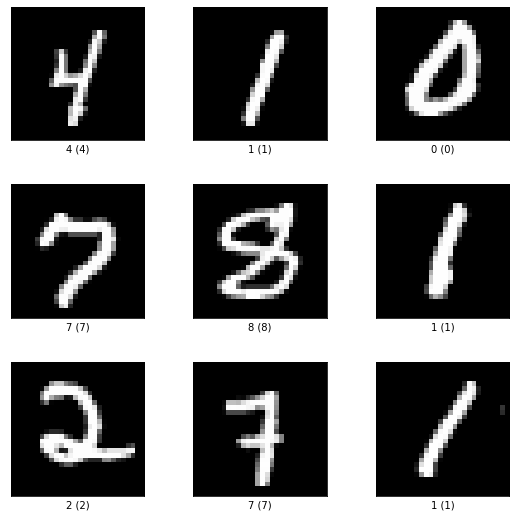

In [2]:
# MNist 데이터 셋 불러오기
import tensorflow_datasets as tfds

mnist,info = tfds.load(
    'mnist', split="train", with_info = True
)

fig = tfds.show_examples(mnist,info)

### GAN, cGAN의 preprocessing 함수

In [3]:
# 이미지 픽셀 값을 -1과 1 사이의 범위로 변경
# 레이블 정보 원 핫 인코딩 cGAN의 y에 해당하는 부분
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image


# cgan같은 경우에는 레이블 데이터가 입력 데이터로 들어가기 때문에 필요하다
def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)

Label : tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


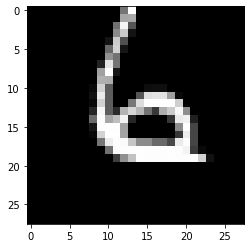

In [4]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break
    

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

### GAN Generator 구성하기
- Tensorflow의 Subclassing 방법 이용

In [5]:
#주석에 맞춰 Generator를 만들어주세요.

from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        # 활성화함수를 'relu'를 사용하고 unit이 128인 Dense Layer
        self.dense_1 = layers.Dense(128,activation='relu')
        # 활성화함수를 'relu'를 사용하고 unit이 256인 Dense Layer
        self.dense_2 = layers.Dense(256,activation='relu')
        # 활성화함수를 'relu'를 사용하고 unit이 512인 Dense Layer
        self.dense_3 = layers.Dense(512,activation='relu')
        # 활성화함수를 하이퍼볼릭 탄젠트를 사용하고 unit이 256인 Dense Layer
        self.dense_4 = layers.Dense(28 * 28 * 1,activation='tanh')
        # layers.Reshape함수로 형상 변환
        self.reshape = layers.Reshape((28,28,1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)


### cGAN generator 구성하기

In [6]:
#주석에 맞춰 Generator를 만들어주세요.

class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        # 노이즈에 Dense layer를 적용
        noise = self.dense_z(noise)
         # 라벨에 Dense layer를 적용
        label = self.dense_y(label)
        # 노이즈와 라벨을 pair가 되게 합친 다음 combined_dense를 적용
        x = layers.Concatenate()([noise, label])
        out = self.combined_dense(x)
        # out = self.combined_dense(tf.concat[noise,label],axis=1)
        # 마지막 Dense Layer를 적용
        out = self.final_dense(out)
        return self.reshape(out)
    
    

### GAN Discriminator 함수

In [7]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        #해당 방식은 반복문을 활용해 layer를 쌓기 때문에 좋은 테크닉중 하나입니다,.
        self.blocks = []
        
        # 마지막 레이어에서는 통과하면서 진짜 및 가짜이미지를 나타내는 1개의 값이 출력
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        # fCN으로 학습하기 위해 파라미터 값을 평활화 한다.
        # 파라미터 값은 Generator가 생성한 28,28,1 크기의 이미지
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x


### cGAN Discriminator 구성
- maxout 레이어
    - 두 레이어 사이를 연결할 때, 여러개의 fully-connected 레이어를 통과시켜서 그중 가장 큰 값을 가져오도록 한다.
    - 즉 주요 목적은 네트워크가 데이터에서 더 복잡하고 추상적이 기능을 학습할 수 있도록 하는
    것이다
    - 아마도 진짜 사진과 가짜 사진 중 더 값이 높은 값을 가져오는 것인 것 같다..

In [8]:
# maxout 함수 구성
# units 차원수를 가진 FCN layer를 pieces개 만큼 만들고 그중 최대값
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)


In [9]:
# cGAN 구성
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        # Maxout(units, pieces)
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        # 이미지 입력 데이터
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)

### 학습 및 테스트 하기

In [10]:
from tensorflow.keras import optimizers, losses

# 이진 분류 loss function
bce = losses.BinaryCrossentropy(from_logits=True)

# GAN의 대표 수식을 함수로 구현해 놓은 것이다
def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)


# optimaizer Adam learning rate 0.0001
gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    


### GAN으로 MNIST 학습하기

In [11]:
# G와 D 생성
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()


@tf.function()
def gan_step(real_images):
    # 노이즈 생성
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

In [13]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.221015691757202, D:0.1378544420003891
[1/10 EPOCHS, 200 ITER] G:2.808912992477417, D:0.08422438055276871
[1/10 EPOCHS, 300 ITER] G:2.41184139251709, D:0.12237437069416046
[1/10 EPOCHS, 400 ITER] G:3.5073657035827637, D:0.11520487815141678
[2/10 EPOCHS, 100 ITER] G:1.5735365152359009, D:0.3587163984775543
[2/10 EPOCHS, 200 ITER] G:3.1060564517974854, D:0.18802952766418457
[2/10 EPOCHS, 300 ITER] G:3.2681567668914795, D:0.1626911163330078
[2/10 EPOCHS, 400 ITER] G:2.947542667388916, D:0.2304266393184662
[3/10 EPOCHS, 100 ITER] G:3.8303627967834473, D:0.07720448821783066
[3/10 EPOCHS, 200 ITER] G:3.3511734008789062, D:0.10491754114627838
[3/10 EPOCHS, 300 ITER] G:2.9429759979248047, D:0.18339338898658752
[3/10 EPOCHS, 400 ITER] G:3.5283703804016113, D:0.09833197295665741
[4/10 EPOCHS, 100 ITER] G:2.7464442253112793, D:0.24265938997268677
[4/10 EPOCHS, 200 ITER] G:3.1857433319091797, D:0.08254124224185944
[4/10 EPOCHS, 300 ITER] G:2.804985284805298, D:0.16217114

(10, 28, 28, 1)
(10, 28, 28)


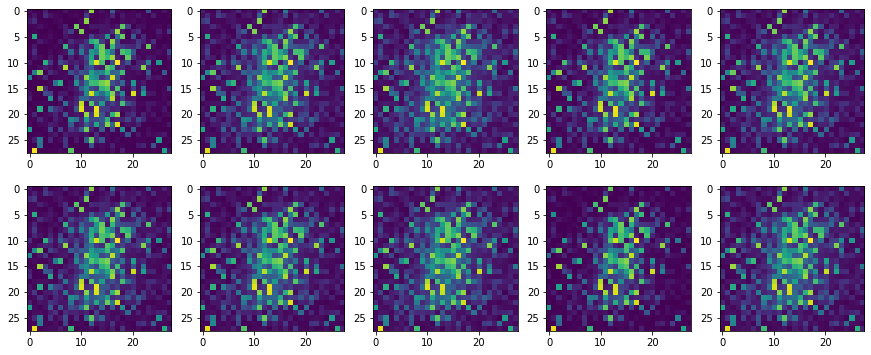

In [14]:
# 테스트
import numpy as np

noise = tf.random.normal([10, 100])

# 생성 이미지 만들기
output = gan_generator(noise)
# output 값 차원 수 줄이기
#(batch, w, h ,c)
print(output.shape)
output = np.squeeze(output.numpy())
print(output.shape)

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

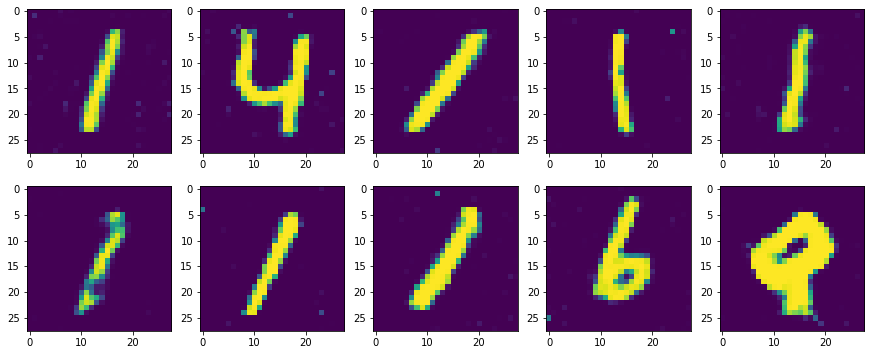

In [15]:
# 500 epoch 만큼 훈련된 가중치로 이미지 생성
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

# 모델 생성, 생성한 모델에 가중치 load
gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

In [19]:
#위에 있는 gan_step()을 참고해서 cgan_step을 완성해주세요.

cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise)
        
        real_out = cgan_discriminator(real_images,labels)
        fake_out = cgan_discriminator(fake_images,labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out,fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 2
count =0
for epoch in range(1, EPOCHS+1):
    for i, (images, labels) in enumerate(cgan_datasets.take(count)):
        gene_loss, disc_loss = cgan_step(images, labels)
        
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

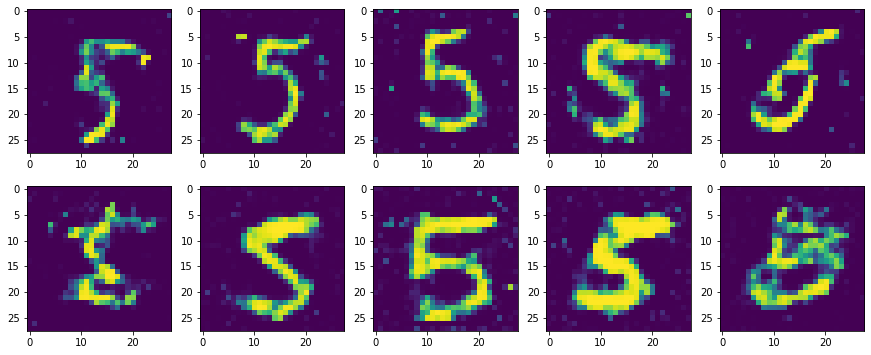

In [20]:
import os
number = 5  # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

### Pix2Pix
- 입력 자체를 조건으로 만든다
- 이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환
- Image to Image
- 이미지를 다루는데 효율적인 convolution layer를 활용

- Generator
    - 입력 이미지와 변환된 이미지의 크기는 동일해야 한다
    - Encoder가 이미지 down sampling -> feature 학습
    - Decoder에서는 dlalwl up sampling
    - bottle neck
        - Encoder의 최종 출력
        - 입력 이미지의 가장 중요한 특징만 담겨 있다.
    - U-Net
        - Encoder와 Decoder가 연결되어 있다.(skip connection)
            - Decoder가 변환된 이미지를 잘 생성하도록 Encoder로 부터 더 많은 추가 정보를 이용하는 방법
        - 기존의  모델보다 비교적 선명한 결과
    - Generator 구조만으로 출력 이미지를 얻을 수 있지만 단순히 이미지의 평균적인 손실만 줄이고자 파라미터를 학습하기 때문에 흐릿하다.
        - L1과 cGAN을 같이 사용하면 더 좋은 결과를 얻을 수 있다고 한다

In [21]:
# 데이터 불러오기
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


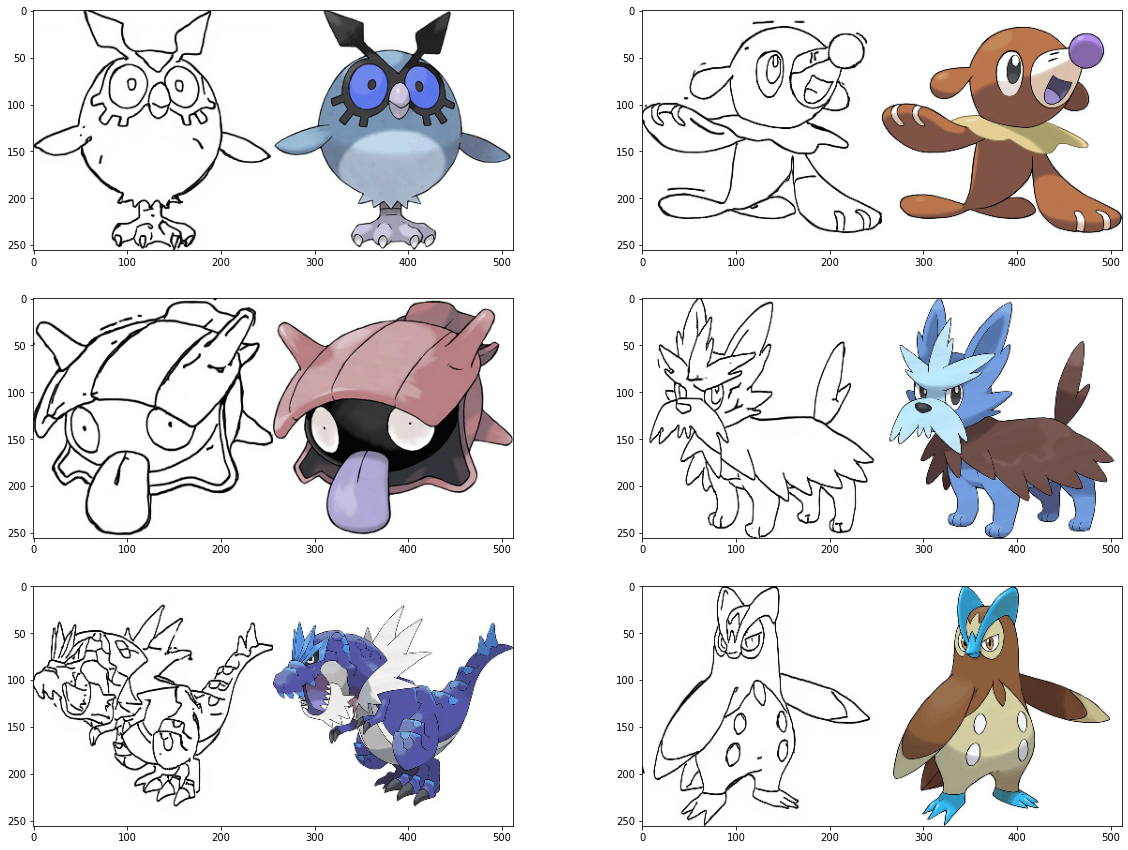

In [22]:
# 이미지 시각화
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [23]:
# 이미지 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


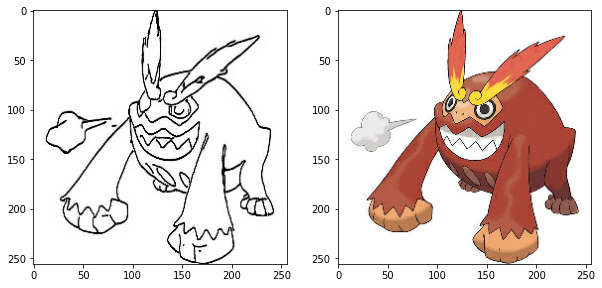

In [24]:
# 2개의 이미지로 나누기
# 이미지를 입력하면 채색된 이미지를 생성
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [25]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


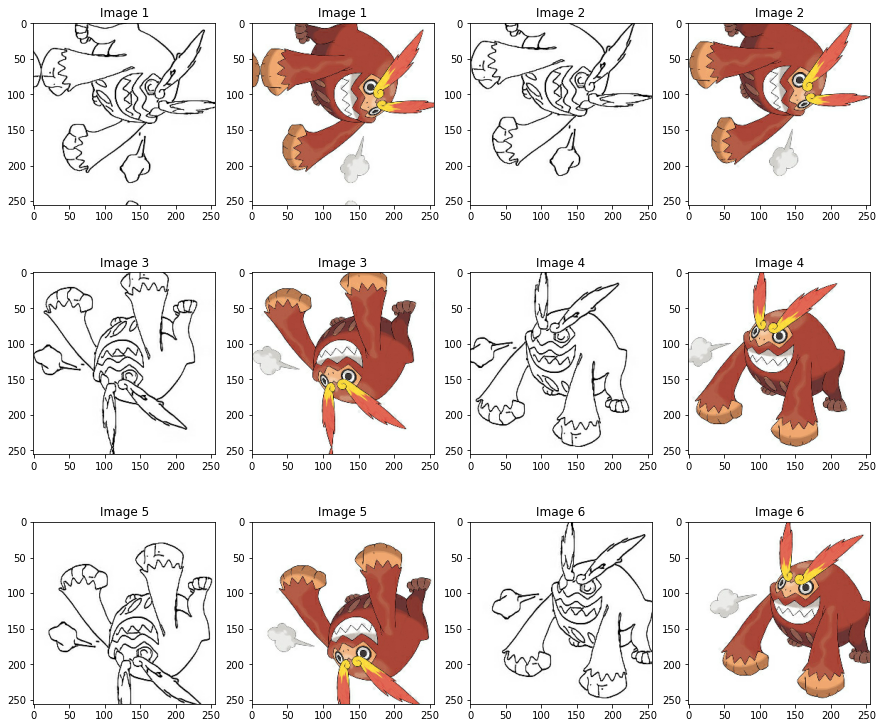

In [26]:
# 데이터에 적용한 결과
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

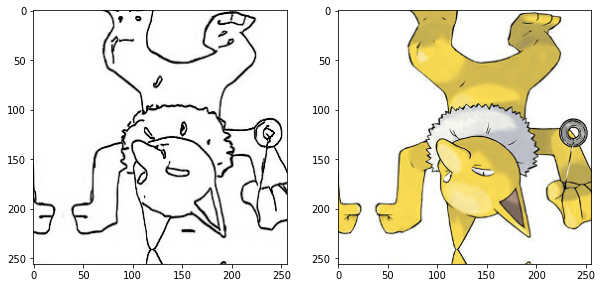

In [27]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### generator 구현하기

In [28]:
from tensorflow.keras import layers, Input, Model


# C64 conv -> batchnorm -> leakyRelu
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [43]:
# Encoder 만들기
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        # for문과 리스트 filter를 활용해서 EncoderBlock을 쌓아주세요.
        # 조건 1. 첫번째 EncoderBlock의 경우 Batch Normalization을 생략해주세요.
        self.blocks = [] 
        
        # 마지막 레이어에서는 통과하면서 진짜 및 가짜이미지를 나타내는 1개의 값이 출력
        for i, f in enumerate(filters):
            self.blocks.append(
                EncodeBlock(f, use_bn=False if i==0 else True)
            )
        
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [44]:
Encoder().get_summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block_24 (EncodeBlock (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_25 (EncodeBlock (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_26 (EncodeBlock (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_27 (EncodeBlock (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_28 (EncodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_29 (EncodeBlock (None, 4, 4, 512)         4196

In [36]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [50]:
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        self.blocks = []
        for i, f in enumerate(filters):
            block_name = f"decoder_block_{i + 1}"
            dropout = True if i < 3 else False
            decode_block = DecodeBlock(f, dropout=dropout)
            self.blocks.append(decode_block)
        # for문을 이용해서 모델을 쌓아주세요.
        # 조건 1. 3번째 block까지는 Dropout을 사용하되 그 이후에는 Dropout을 사용하지 마세요.
        # for문이 끝난 다음 Conv2DTranspose를 쌓아주되 output 차원수는 3, filter 사이즈는 4, stride는 2로 구성해주시고 자동 패딩 적용해주시되 bias는 사용하지 않습니다.
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

In [51]:
Decoder().get_summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block_21 (DecodeBlock (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_22 (DecodeBlock (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_23 (DecodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_24 (DecodeBlock (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_25 (DecodeBlock (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_26 (DecodeBlock (None, 64, 64, 128)       5248

In [52]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_6 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_5 (Decoder)          (None, 128, 128, 64)      19539712  
Total params: 39,084,288
Trainable params: 39,073,408
Non-trainable params: 10,880
_________________________________________________________________


### U-Net Generatror
- Decoder 구조 내 파라미터가 많아진다. 레이어에서 사용된 필터 수는 두종류의 Decoder 모두 동일하지만 크기가 다르다.
- 기존 Decoder는 출력 크기가 16,16,512 라면 Convolution 필터 크기는 4,4,512
- UNet generator의 경우는 Convolution 필터 크기가 4,4,512+512이다

In [53]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        # skip connection을 위해 만들어진 feature list
        features = features[:-1]
        
        # Encoder 마지막 출력을 Decoder로 직접 입력, skip connection 대상 아님            
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [54]:
UNetGenerator().get_summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_48 (EncodeBlock)   (None, 128, 128, 64) 3072        input_10[0][0]                   
__________________________________________________________________________________________________
encode_block_49 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_48[0][0]            
__________________________________________________________________________________________________
encode_block_50 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_49[0][0]            
____________________________________________________________________________________________

### Discirminator 만들기

In [55]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 


In [59]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_102 (Bat (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [71]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64,128,256,512,1]
        self.blocks = [layers.Concatenate()]
        # For문을 활용해서 DiscBlock을 쌓아주세요.
        # 조건 1 : 3번째까지 stride는 2로 주되 이후에는 1로 주세요
        # 조건 2 : 3번째까지 custom padding을 주지 않아도 되는데 이후에는 주세요.
        # 조건 3: 1번째와 5번째에서는 Batch Normalization을 사용하지 마세요.
        # 조건 4 : 1번째부터 4번째까지 LeakyReLU를 적용하고 마지막에는 sigmoid를 적용하세요. (sigmoid의 경우 따로 정의해야 합니다)
        for i in range(0,len(filters)):
            stride = 2 if i < 3 else 1
            custom_pad = False if i < 3 else True
            use_bn = False if i == 0 or i == 4 else True
            act = True if i < 5 else False

            self.blocks.append(
                DiscBlock(
                    n_filters=filters[i],
                    stride=stride,
                    custom_pad=custom_pad,
                    use_bn=use_bn,
                    act=act
                )
            )

        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x, y):
        #[[YOUR CODE]]
 
        out = self.blocks[0]([x,y])
        for block in self.blocks[1:]:
            out = block(out)

        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [72]:
Discriminator().get_summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_16 (Concatenate)    (None, 256, 256, 6)  0           input_25[0][0]                   
                                                                 input_26[0][0]                   
__________________________________________________________________________________________________
disc_block_24 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_16[0][0]      

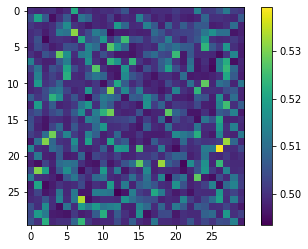

In [73]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [74]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


In [75]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [1]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
    # 이전에 배웠던 내용을 토대로 train_step을 구성해주세요.
        fake_images = generator(sketch)
        
        real_disc = discriminator(real_colored,sketch)
        fake_disc = discriminator(fake_images,sketch)
        
        gene_loss,l1_loss = get_gene_loss(fake_images, real_colored, fake_disc)
        disc_loss = get_disc_loss(fake_disc, real_disc)
        gene_total_loss = l1_loss*100+gene_loss

    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


NameError: name 'tf' is not defined